<a href="https://colab.research.google.com/github/AhmedRezaShams/Python/blob/main/MobileNet_Fine_Tuned_Reza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.utils import load_img, img_to_array
#from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf

In [5]:
!pip install -U -q PyDrive  #py framework
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client  import GoogleCredentials  #clint library
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='fabric_defect.zip'"}).GetList()[0]['id'] #is a method call in the Google Drive API for Python that lists all the files in the current user's Google Drive that match a certain query.
f = drive.CreateFile({'id': fid})
f.GetContentFile('fabric_defect.zip')
f.keys()
!unzip fabric_defect.zip


Archive:  fabric_defect.zip
   creating: Fabric defect/
   creating: Fabric defect/test/
   creating: Fabric defect/test/hole/
  inflating: Fabric defect/test/hole/1.jpg  
  inflating: Fabric defect/test/hole/10.jpg  
  inflating: Fabric defect/test/hole/10_processed (1).jpg  
  inflating: Fabric defect/test/hole/10_processed (2).jpg  
  inflating: Fabric defect/test/hole/10_processed (3).jpg  
  inflating: Fabric defect/test/hole/11.jpg  
  inflating: Fabric defect/test/hole/11_processed (1).jpg  
  inflating: Fabric defect/test/hole/11_processed (2).jpg  
  inflating: Fabric defect/test/hole/11_processed (3).jpg  
  inflating: Fabric defect/test/hole/12.jpg  
  inflating: Fabric defect/test/hole/12_processed (1).jpg  
  inflating: Fabric defect/test/hole/12_processed (2).jpg  
  inflating: Fabric defect/test/hole/12_processed (3).jpg  
  inflating: Fabric defect/test/hole/13.jpg  
  inflating: Fabric defect/test/hole/13_processed (1).jpg  
  inflating: Fabric defect/test/hole/13_proc

In [6]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [7]:
folder_path = "/content/Fabric defect" 
# folder_path = "../input/face-expression-recognition-dataset/images/"
# validation_folder_path = "../input/face-expression-recognition-dataset/images/"

In [23]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/Fabric defect/train'
SIZE = (300,300) 
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 80

# get the total number of files to process
total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

# use tqdm to display a progress bar
with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1) # increment the progress bar
            else:
                continue


Processing Images: 100%|██████████| 666/666 [00:02<00:00, 256.71it/s]


In [24]:
'''
expression = 'happy'
plt.style.use('dark_background')
plt.figure(figsize=(12, 12))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)
    plt.imshow(img)  
plt.show()
'''

'\nexpression = \'happy\'\nplt.style.use(\'dark_background\')\nplt.figure(figsize=(12, 12))\nfor i in range(1, 10):\n    plt.subplot(3, 3, i)\n    img = load_img(folder_path + "train/" + expression + "/" + os.listdir(folder_path + "train/" + expression)[i], target_size=SIZE)\n    plt.imshow(img)  \nplt.show()\n'

In [25]:
batch_size = 32
picture_size = SIZE
datagen_train = ImageDataGenerator(rotation_range=.5, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
                                )

datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input )

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=.5,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.2,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.1,
                                    fill_mode='nearest')

In [26]:
train_generator = train_datagen.flow_from_directory(folder_path ,
                                                    target_size=(picture_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_set = test_datagen.flow_from_directory(folder_path ,
                                                        target_size=(picture_size),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 1735 images belonging to 3 classes.
Found 1735 images belonging to 3 classes.


In [27]:

from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


no_of_classes = 3

# Define the base model
base_model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add some trainable layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
predictions = Dense(no_of_classes, activation='softmax')(x)

# Define the model with the new layers
model = Model(inputs=base_model.input, outputs=predictions)

In [28]:
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=3,
                                verbose=1,
                                restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                patience=2,
                                verbose=1)

callbacks = [early_stopping, lr_scheduler]


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

last_epoch = 0
# Train the model on your dataset with a smaller learning rate
history = model.fit(train_generator, epochs=10, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 1/10
55/55 [==============================] - 393s 7s/step - loss: 0.6771 - accuracy: 0.6703 - val_loss: 0.4952 - val_accuracy: 0.6715 - lr: 0.0010
Epoch 2/10
 2/55 [>.............................] - ETA: 4:08 - loss: 0.5349 - accuracy: 0.6406

In [19]:
# Unfreeze some of the layers in the base model
for layer in model.layers[-10:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

last_epoch = 10
# Fine-tune the model on your dataset
history = model.fit(train_generator, epochs=30, validation_data=validation_set, callbacks=[early_stopping,lr_scheduler], 
                    steps_per_epoch=len(train_generator), validation_steps=len(validation_set), 
                    class_weight=None, initial_epoch=last_epoch)

Epoch 11/30
55/55 [==============================] - 87s 1s/step - loss: 1.0957 - accuracy: 0.3706 - val_loss: 1.0753 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 12/30
55/55 [==============================] - 65s 1s/step - loss: 1.0766 - accuracy: 0.3741 - val_loss: 1.0775 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 13/30
55/55 [==============================] - 66s 1s/step - loss: 1.0831 - accuracy: 0.3729 - val_loss: 1.0744 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 14/30
55/55 [==============================] - 63s 1s/step - loss: 1.0771 - accuracy: 0.3960 - val_loss: 1.0745 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 15/30
55/55 [==============================] - ETA: 0s - loss: 1.0836 - accuracy: 0.3700
Epoch 15: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
55/55 [==============================] - 63s 1s/step - loss: 1.0836 - accuracy: 0.3700 - val_loss: 1.0816 - val_accuracy: 0.3839 - lr: 0.0010
Epoch 16/30
55/55 [==============================] - 74s 1s/step - lo

In [21]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

55/55 [==============================] - 31s 559ms/step - loss: 1.0744 - accuracy: 0.3839
Test accuracy: 0.3838616609573364


In [ ]:
model.save('/kaggle/working/my_model_emo.h5')

1/1 [==============================] - 1s 928ms/step


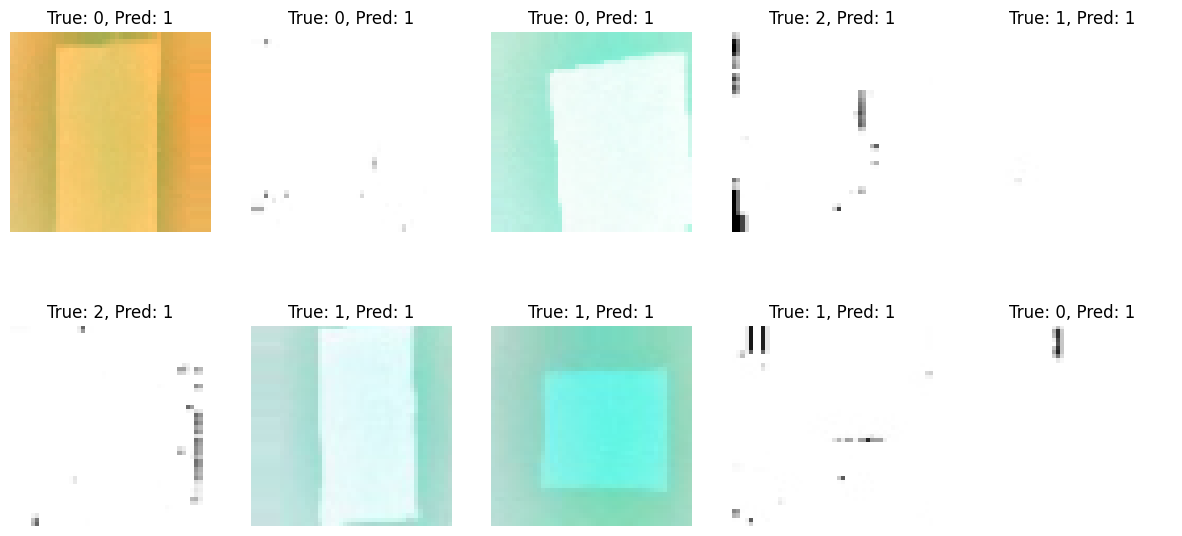

accuracy:  40.0


In [22]:
# Get a batch of 50 random images from the validation set
test_batch = validation_set.next()
images = test_batch[0][:10]
true_labels = test_batch[1][:10]

# Make predictions using the trained model
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the images with their true and predicted labels
fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()
acc = 0
for i in range(len(images)):
    # Rescale the pixel values from [0, 1] to [0, 255] and convert to integers
    img = (images[i] * 255).astype(np.uint8)
    # Invert the pixel values
    img = 255 - img
    axs[i].imshow(img)
    if np.where(true_labels[i] == 1)[0] ==  pred_labels[i]:
        acc += 1
    axs[i].set_title(f'True: {np.where(true_labels[i] == 1)[0][0]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')
plt.show()
print("accuracy: ",(acc*100)/10)